In [2]:
import keras
import numpy as np
import sklearn
from keras import backend as K
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
import pickle
import datetime
import dill
from collections import defaultdict
from progressbar import progressbar
import matplotlib as mpl
from scipy import stats
from keras.optimizers import Adam

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
%matplotlib inline  
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [25,5]

Using TensorFlow backend.


In [ ]:
!pip install dill
!pip install progressbar
!pip install pydrive

In [13]:
gauth = GoogleAuth()
gauth.CommandLineAuth()
drive = GoogleDrive(gauth)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=1057564047652-3pjn8gqutrpm7i9q7n26o60duk1lepnn.apps.googleusercontent.com&response_type=code&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&access_type=offline

Enter verification code: 4/sgDHN7usQpGQL8lCFkGF7FvnUVrRIy6EjAegNxNj_FdQXBU4cQJYdoo
Authentication successful.


In [10]:
root_project_dir = '1ZCl2DH_E5_Ru8hgOVfIlgNMthDWtztbG'
input_image_dir = '1D3NVa_l5oTNhPmNupq1tS5pzEjJ15shu'
weight_dir = '147yyNR1WUICzW8ts93uzisCIbSj4xNAb'

In [11]:
# Recursive list file
# depth is level of recursive searching
# if depth is negative, searching will continue until meet leaf nodes
def get_files_ID(parent, depth=1):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % parent}).GetList()
    d = dict()    
    if(depth == 0 ): return d  
  
    for f in file_list:
        if f['mimeType']=='application/vnd.google-apps.folder': # if folder
            d[f['title']] = f['id']
            sub_d = get_files_ID(f['id'], depth-1)
            d.update(sub_d)
        else:
            d[f['title']] = f['id']  
    return d

# file_name is a target file name for downloading
# source_dir is a gdrive directory id that's contains file. If not specify, all folder from root will be searched.
# files_id is a target gdrive file id. If specify, file_name won't be used.
# byte indicates wheter return in bytes
def read_file(file_name = None, file_id=None, source_dir=None, byte=False, root_project_dir=root_project_dir):
    if(file_name == None):
        return None
  
    if(file_id == None):
        files_id = get_files_ID(root_project_dir, depth=-1)
    if file_name not in files_id.keys():
        print("file doesn't exits")
        return None
    
    file_id = files_id[file_name]    
    downloaded = drive.CreateFile({'id': file_id})
    if(byte):
        return bytes.fromhex(downloaded.GetContentString())
    else:
        return StringIO(downloaded.GetContentString())
    
    
# file_name is a target file name for writing
# content is in string format
def write_file(file_name = None, content = None, folder_id = root_project_dir, overwrite = False):
    files_id = get_files_ID(folder_id)
    if(file_name in files_id.keys()):
        if(overwrite):
            uploaded = drive.CreateFile({"title": file_name, "parents": [{"kind": "drive#fileLink", "id": folder_id}], "id": files_id[file_name]})
        else:
            print("file exist")
            return
    else:
        uploaded = drive.CreateFile({"title": file_name, "parents": [{"kind": "drive#fileLink", "id": folder_id}]})
  
    uploaded.SetContentString(content)
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

# download file from gdrive into save_dir
# file_name is a target file name for downloading
# file_id is a target gdrive file id. If specify, file_name won't be used.
# source_dir is a gdrive directory id that's contains file. If not specify, all folder from root will be searched.
# save_dir is local save for saving a file e.g. test_folder/image
# byte indicates wheter return in bytes
def download_file(file_name = None, file_id = None, source_dir = None, save_dir = None, byte=False, root_project_dir=root_project_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
  
    if(file_name == None and file_id == None):
        print('file is not been specified')
        return None
        
    if(file_id == None):
        if(source_dir != None):
            files_id = get_files_ID(source_dir, depth=1)
        else:
            files_id = get_files_ID(root_project_dir, depth=-1)
        if file_name not in files_id.keys():
            print("file doesn't exits")
            return None
        file_id = files_id[file_name]      

    downloaded = drive.CreateFile({'id': file_id})  
    target_path = os.path.join(save_dir,downloaded['title'])
    downloaded.GetContentFile(target_path)  # Save Drive file as a local file
    print('Downloading file %s from Google Drive to %s' % (downloaded['title'],target_path))


# take content as local object filename, upload it to drive
# file_name is target saving name in gdrive
# content is a local file name
def upload_file(file_name = None, content = None, folder_id = root_project_dir, overwrite = False):
    files_id = get_files_ID(folder_id)
    if(file_name in files_id.keys()):
        if(overwrite):
            uploaded = drive.CreateFile({"title": file_name, "parents": [{"kind": "drive#fileLink", "id": folder_id}], "id": files_id[file_name], 'mimeType':'image/png'})
        else:
            print("file exist")
        return
    else:
        uploaded = drive.CreateFile({"title": file_name, "parents": [{"kind": "drive#fileLink", "id": folder_id}], 'mimeType':'image/png'})
  
    uploaded.SetContentFile(content)
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [3]:
# input image (30x200) as png file
# blur_dir = 'drive/My Drive/computer_vision/input_images/datav2/blur_img/train'
# original_dir = 'drive/My Drive/computer_vision/input_images/datav2/original_img/train'
# blur_train = 'data/train/blur'
# original_train = 'data/train/original'
# blur_dev = 'data/dev/blur'
# original_dev = 'data/dev/original'

train_blur_dirs = [('datav7/train30000/median','median'),
                   ('datav7/train30000/gaussian','gaussian'),
                   ('datav7/train30000/down','down')]
train_ori_dir = 'datav7/train30000/ori'

dev_blur_dirs = [('datav7/dev20000/median','median'),
                 ('datav7/dev20000/gaussian','gaussian'),
                 ('datav7/dev20000/down','down')]
dev_ori_dir = 'datav7/dev20000/ori'


test_blur_dirs = [('datav7/test20000/median','median'),
                 ('datav7/test20000/gaussian','gaussian'),
                 ('datav7/test20000/down','down')]
test_ori_dir = 'datav7/test20000/ori'

In [58]:
download_file(file_name = None, file_id = "1-QSx_GyGNWSUI75rbZIInlqejriOFE8Y", source_dir = root_project_dir, save_dir = '.')

In [31]:
%%capture
!unzip datav5.zip

In [4]:
X_train = []
y_train = []
train_size = 30000 # for images in each folder

for (train_blur_dir,prefix) in train_blur_dirs:
    for i in range(train_size):
        X_train.append(os.path.join(train_blur_dir, '{}{}.png'.format(prefix,i)))
        y_train.append(os.path.join(train_ori_dir, '{}{}.png'.format('ori',i)))
        
X_dev = []
y_dev = []
dev_size = 20000 # for images in each folder

for (dev_blur_dir,prefix) in dev_blur_dirs:
    for i in range(dev_size):
        X_dev.append(os.path.join(dev_blur_dir, '{}{}.png'.format(prefix,i)))
        y_dev.append(os.path.join(dev_ori_dir, '{}{}.png'.format('ori',i)))
        
        
X_test = []
y_test = []
test_size = 20000 # for images in each folder

for (test_blur_dir,prefix) in test_blur_dirs:
    for i in range(test_size):
        X_test.append(os.path.join(test_blur_dir, '{}{}.png'.format(prefix,i)))
        y_test.append(os.path.join(test_ori_dir, '{}{}.png'.format('ori',i)))

In [148]:
from skimage.io import imread
from skimage import color
from keras.utils import Sequence

class generator(Sequence):
    def __init__(self, x_set, y_set, batch_size=128):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([imread(file_name) for file_name in batch_x])/255., np.array([imread(file_name) for file_name in batch_y])/255.
#         X = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_x])
#         y = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_y])
#         return X.reshape(-1,50,300,1), y.reshape(-1,50,300,1)
    
    
class pred_generator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set          
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([imread(file_name) for file_name in batch_x])/255.
#         X = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_x])
#         return X.reshape(-1,50,300,1)

In [15]:
def psnr(y_true, y_pred):    
    return tf.image.psnr(y_true, y_pred, max_val=1)
  
    
def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))*255.

### Models

In [150]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose
from keras.models import Model

def get_model(input_shape): 
    #input 1-image (inverse)
    x = Input(shape = input_shape)
    c1 = Conv2D(64, 9, strides=1, activation = 'relu', padding='same')(x)
    c2 = Conv2D(32, 1, strides=1, activation = 'relu', padding='same')(c1)
    c3 = Conv2D(input_shape[2], 5, strides=1, activation = 'relu', padding='same')(c2)
    model = Model(inputs = x, outputs = c3)
    return model


def get_model2(input_shape): 
    #input image
    x = Input(shape = input_shape)

    c1 = Conv2D(64, 3, strides=1, padding='same')(x)
    h1 = Activation('relu')(c1)
    
    c1 = Conv2D(64, 2, strides=1, padding='same')(x)
    h1 = Activation('relu')(c1)

    c2 = Conv2D(32, 3, strides=1, activation = 'relu', padding='same')(h1)
    h2 = Activation('relu')(c2)

    c3 = Conv2D(32, 1, strides=1, activation = 'relu', padding='same')(h2)
    h3 = Activation('relu')(c3)

    c3 = Conv2D(32, 3, strides=1, activation = 'relu', padding='same')(h2)
    h3 = Activation('relu')(c3)
    
    c4 = Conv2D(input_shape[2], 3, strides=1, padding='same')(h3)
    h4 = Activation('relu')(c4)

    model = Model(inputs = x, outputs = h4)

    return model


def get_model5(input_shape): 
    #input image 
    x = Input(shape = input_shape) 
    c1 = Conv2D(64, 7, strides=4, padding='same')(x) 
    h1 = Activation('relu')(c1) 
    
    c2 = Conv2D(64, 3, strides=2, activation = 'relu', padding='same')(h1) 
    h2 = Activation('relu')(c2) 
    
    c3 = Conv2D(32, 1, strides=1, activation = 'relu', padding='same')(h2) 
    h3 = Activation('relu')(c3) 
    
    c4 = Conv2DTranspose(64, 7, strides=4, activation = 'relu', padding='same')(h3) 
    h4 = Activation('relu')(c4) 
    
    c5 = Conv2DTranspose(64, 3, strides=2, activation = 'relu', padding='same')(h4) 
    h5 = Activation('relu')(c5) 
    
    c6 = Conv2DTranspose(input_shape[2], 1, strides=1, activation = 'relu', padding='same')(h5) 
    h6 = Activation('relu')(c6) 
    
    model = Model(inputs = x, outputs = h6) 
    
    return model

def get_model4(input_shape):
    x = Input(shape = input_shape)
    model = Model(inputs = x, outputs = x)
    return model

### Training model 1

In [135]:
K.clear_session()
model = get_model(input_shape=(100,600,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 600, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 600, 64)      5248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 600, 32)      2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 600, 1)       801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [231]:
model.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'v6_model_gray.hdf5'
log_path = 'tensorboard/v6_model_gray'

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1),
#     EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    TensorBoard(log_dir=log_path, write_graph=False, write_grads=False, batch_size=150)
]
model.fit_generator(generator(X_train,y_train,batch_size=150),
                    validation_data=generator(X_dev,y_dev, batch_size=150),
                    epochs=20, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

In [ ]:
model.load_weights(saved_path)

In [104]:
upload_file(file_name = saved_path, content = saved_path, folder_id = root_project_dir, overwrite = False)

Uploaded file with ID 1mjaNZQpjxaZff1w_1m6ZZ7p0wffyJuD5


# Training model 2

In [ ]:
# K.clear_session()
model = get_model2(input_shape=(50,300,1))
model.summary()

In [ ]:
from keras.optimizers import Adam
model.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'v7_model2.hdf5'
log_path = 'tensorboard/v7_model2'

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1),
#     EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    TensorBoard(log_dir=log_path, write_graph=False, write_grads=False, batch_size=128)
]
model.fit_generator(generator(X_train,y_train,batch_size=128),
                    validation_data=generator(X_dev,y_dev, batch_size=128),
                    epochs=20, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

Epoch 1/20
704/704 [==============================] - 356s 505ms/step - loss: 0.0243 - psnr: 18.4802 - mae: 18.7211 - val_loss: 0.0150 - val_psnr: 19.5644 - val_mae: 14.5168

Epoch 00001: val_loss improved from inf to 0.01498, saving model to v7_model2.hdf5
Epoch 2/20
704/704 [==============================] - 354s 503ms/step - loss: 0.0138 - psnr: 20.1778 - mae: 13.0390 - val_loss: 0.0124 - val_psnr: 20.9201 - val_mae: 9.8929

Epoch 00002: val_loss improved from 0.01498 to 0.01238, saving model to v7_model2.hdf5
Epoch 3/20
704/704 [==============================] - 355s 505ms/step - loss: 0.0123 - psnr: 20.6162 - mae: 12.4277 - val_loss: 0.0117 - val_psnr: 20.6124 - val_mae: 13.5536

Epoch 00003: val_loss improved from 0.01238 to 0.01173, saving model to v7_model2.hdf5
Epoch 4/20
704/704 [==============================] - 356s 505ms/step - loss: 0.0111 - psnr: 21.0450 - mae: 11.3347 - val_loss: 0.0102 - val_psnr: 21.6388 - val_mae: 8.5876

Epoch 00004: val_loss improved from 0.01173 t

In [31]:
model.load_weights(saved_path)

In [147]:
upload_file(file_name = saved_path, content = saved_path, folder_id = weight_dir, overwrite = False)

Uploaded file with ID 1QxGmFELev7O9radfeiCj4LTn11RzrQL9


### test

In [114]:
model.evaluate_generator(generator(X_test,y_test,batch_size=128), verbose=1)

469/469 [==============================] - 131s 279ms/step


[0.0051385584564258655, 24.239463477579754, 6.053068202463786]

In [116]:
model.evaluate_generator(generator(X_test[:20000],y_test[:20000],batch_size=128), verbose=1)

157/157 [==============================] - 44s 281ms/step


[0.007146378836035729, 23.531542376708984, 6.02276873626709]

In [117]:
model.evaluate_generator(generator(X_test[20000:40000],y_test[20000:40000],batch_size=128), verbose=1)

157/157 [==============================] - 44s 282ms/step


[0.004515300413221121, 24.569161639404296, 6.415759935760498]

In [118]:
model.evaluate_generator(generator(X_test[40000:],y_test[40000:],batch_size=128), verbose=1)

157/157 [==============================] - 45s 286ms/step


[0.003753996175527573, 24.617686431884767, 5.720676016998291]

# Model2 color

In [151]:
# K.clear_session()
model = get_model2(input_shape=(50,300,3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50, 300, 3)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 300, 64)       832       
_________________________________________________________________
activation_23 (Activation)   (None, 50, 300, 64)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 300, 32)       18464     
_________________________________________________________________
activation_24 (Activation)   (None, 50, 300, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 300, 32)       9248      
_________________________________________________________________
activation_26 (Activation)   (None, 50, 300, 32)       0         
__________

In [152]:
from keras.optimizers import Adam
model.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'v7_model2_c.hdf5'
log_path = 'tensorboard/v7_model2_c'

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    TensorBoard(log_dir=log_path, write_graph=False, write_grads=False, batch_size=128)
]
model.fit_generator(generator(X_train,y_train,batch_size=128),
                    validation_data=generator(X_dev,y_dev, batch_size=128),
                    epochs=20, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

Epoch 1/20
704/704 [==============================] - 396s 562ms/step - loss: 0.0254 - psnr: 18.5806 - mae: 19.1356 - val_loss: 0.0149 - val_psnr: 19.8827 - val_mae: 14.6705

Epoch 00001: val_loss improved from inf to 0.01492, saving model to v7_model2_c.hdf5
Epoch 2/20
704/704 [==============================] - 382s 542ms/step - loss: 0.0134 - psnr: 20.3342 - mae: 12.6213 - val_loss: 0.0136 - val_psnr: 19.7898 - val_mae: 17.0029

Epoch 00002: val_loss improved from 0.01492 to 0.01356, saving model to v7_model2_c.hdf5
Epoch 3/20
704/704 [==============================] - 393s 558ms/step - loss: 0.0119 - psnr: 20.7883 - mae: 11.5474 - val_loss: 0.0108 - val_psnr: 21.2847 - val_mae: 9.8510

Epoch 00003: val_loss improved from 0.01356 to 0.01077, saving model to v7_model2_c.hdf5
Epoch 4/20
704/704 [==============================] - 392s 557ms/step - loss: 0.0109 - psnr: 21.0832 - mae: 10.9947 - val_loss: 0.0109 - val_psnr: 20.9922 - val_mae: 12.7990

Epoch 00004: val_loss did not improve 

### test

In [154]:
model.evaluate_generator(generator(X_test,y_test,batch_size=128), verbose=1)

469/469 [==============================] - 109s 232ms/step


[0.006011740107834339, 23.762246304321287, 6.601704537455241]

In [155]:
model.evaluate_generator(generator(X_test[:20000],y_test[:20000],batch_size=128), verbose=1)

157/157 [==============================] - 36s 229ms/step


[0.008369921126961707, 22.931501068115235, 6.6950571197509765]

In [156]:
model.evaluate_generator(generator(X_test[20000:40000],y_test[20000:40000],batch_size=128), verbose=1)

157/157 [==============================] - 36s 228ms/step


[0.005667616917192936, 23.962802020263673, 7.0189738342285155]

In [157]:
model.evaluate_generator(generator(X_test[40000:],y_test[40000:],batch_size=128), verbose=1)

157/157 [==============================] - 36s 232ms/step


[0.003997682281583548, 24.392435638427735, 6.091082752990722]

In [158]:
upload_file(file_name = saved_path, content = saved_path, folder_id = weight_dir, overwrite = False)

Uploaded file with ID 1eCGoPcsg27cWLoQNVmhbGLi3rL9OU7ZP


# train model3

In [143]:
# K.clear_session()
model = get_model5(input_shape=(50,300,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 300, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 75, 64)        1664      
_________________________________________________________________
activation_15 (Activation)   (None, 13, 75, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 38, 64)         36928     
_________________________________________________________________
activation_16 (Activation)   (None, 7, 38, 64)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 38, 64)         36928     
_________________________________________________________________
activation_17 (Activation)   (None, 7, 38, 64)         0         
__________

In [ ]:
from keras.optimizers import Adam
model.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'v7_model3_o.hdf5'
log_path = 'tensorboard/v7_model3_o'

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1),
#     EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    TensorBoard(log_dir=log_path, write_graph=False, write_grads=False, batch_size=128)
]
model.fit_generator(generator(X_train,y_train,batch_size=128),
                    validation_data=generator(X_dev,y_dev, batch_size=128),
                    epochs=20, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

Epoch 1/20
704/704 [==============================] - 356s 505ms/step - loss: 0.0243 - psnr: 18.4802 - mae: 18.7211 - val_loss: 0.0150 - val_psnr: 19.5644 - val_mae: 14.5168

Epoch 00001: val_loss improved from inf to 0.01498, saving model to v7_model2.hdf5
Epoch 2/20
704/704 [==============================] - 354s 503ms/step - loss: 0.0138 - psnr: 20.1778 - mae: 13.0390 - val_loss: 0.0124 - val_psnr: 20.9201 - val_mae: 9.8929

Epoch 00002: val_loss improved from 0.01498 to 0.01238, saving model to v7_model2.hdf5
Epoch 3/20
704/704 [==============================] - 355s 505ms/step - loss: 0.0123 - psnr: 20.6162 - mae: 12.4277 - val_loss: 0.0117 - val_psnr: 20.6124 - val_mae: 13.5536

Epoch 00003: val_loss improved from 0.01238 to 0.01173, saving model to v7_model2.hdf5
Epoch 4/20
704/704 [==============================] - 356s 505ms/step - loss: 0.0111 - psnr: 21.0450 - mae: 11.3347 - val_loss: 0.0102 - val_psnr: 21.6388 - val_mae: 8.5876

Epoch 00004: val_loss improved from 0.01173 t

In [31]:
model.load_weights(saved_path)

In [ ]:
upload_file(file_name = saved_path, content = saved_path, folder_id = weight_dir, overwrite = False)

### test

In [114]:
model.evaluate_generator(generator(X_test,y_test,batch_size=128), verbose=1)

469/469 [==============================] - 131s 279ms/step


[0.0051385584564258655, 24.239463477579754, 6.053068202463786]

In [116]:
model.evaluate_generator(generator(X_test[:20000],y_test[:20000],batch_size=128), verbose=1)

157/157 [==============================] - 44s 281ms/step


[0.007146378836035729, 23.531542376708984, 6.02276873626709]

In [117]:
model.evaluate_generator(generator(X_test[20000:40000],y_test[20000:40000],batch_size=128), verbose=1)

157/157 [==============================] - 44s 282ms/step


[0.004515300413221121, 24.569161639404296, 6.415759935760498]

In [118]:
model.evaluate_generator(generator(X_test[40000:],y_test[40000:],batch_size=128), verbose=1)

157/157 [==============================] - 45s 286ms/step


[0.003753996175527573, 24.617686431884767, 5.720676016998291]

In [ ]:
model.evaluate_generator(generator(X_test,y_test,batch_size=128), verbose=1)

# Compare

In [160]:
# test_path = 'drive/My Drive/computer_vision/testing2'
def comparing(model, X, y, batch_size=10):
  
  for b, (source, target) in enumerate(generator(X, y, batch_size=batch_size)):
    
    results = model.predict(source)
    
    fig, axes = plt.subplots(len(results), 3,  figsize=(100,5*len(results)))
    
    for i, result in enumerate(results):                
#       mae = np.mean(np.abs(result - target[i]))*255
#       mse = np.mean((result - target[i])**2)*255                      
#       plt.suptitle("mea {} mse {}".format(mae,mse))             
#       axes[i,0].imshow(np.reshape(source[i], (50,300)), cmap='gray')
#       axes[i,1].imshow(np.reshape(result, (50,300)), cmap='gray')    
#       axes[i,2].imshow(np.reshape(target[i], (50,300)), cmap='gray')
      axes[i,0].imshow(source[i])
      axes[i,1].imshow(result)
      axes[i,2].imshow(target[i])
#     print(i, len(results))
#     fig.savefig(os.path.join(test_path,'test_{}-{}.png'.format(b*batch_size, b*batch_size+len(results))))
      fig.show()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

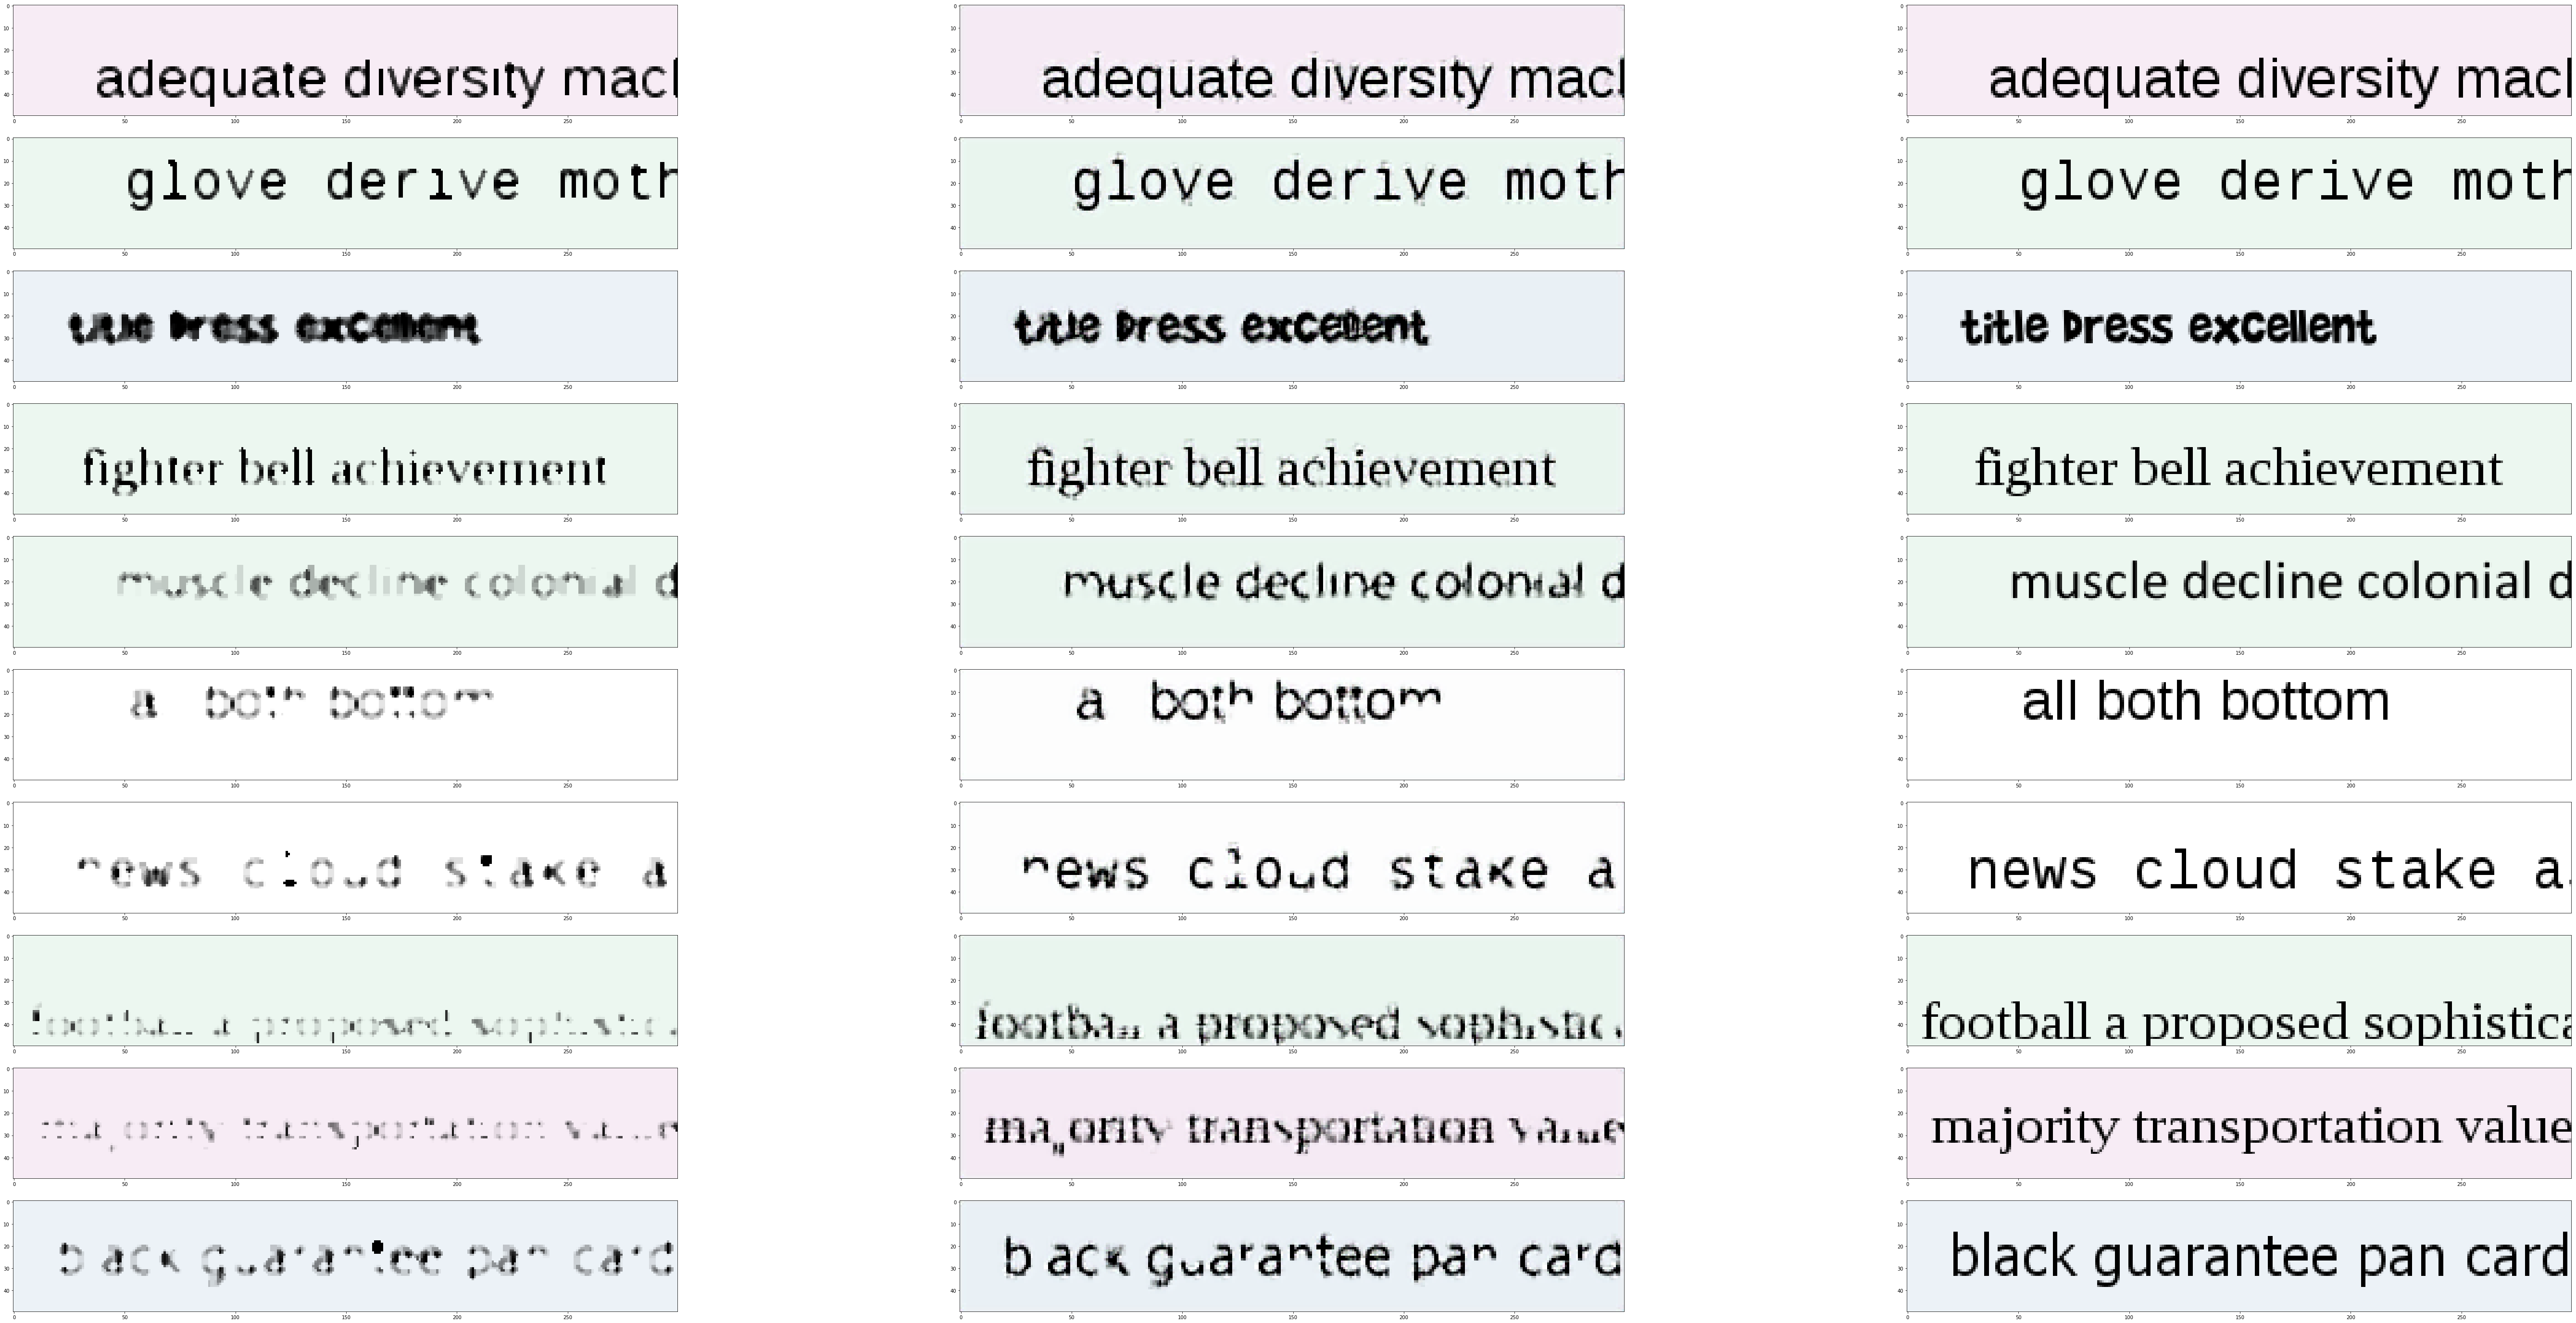

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

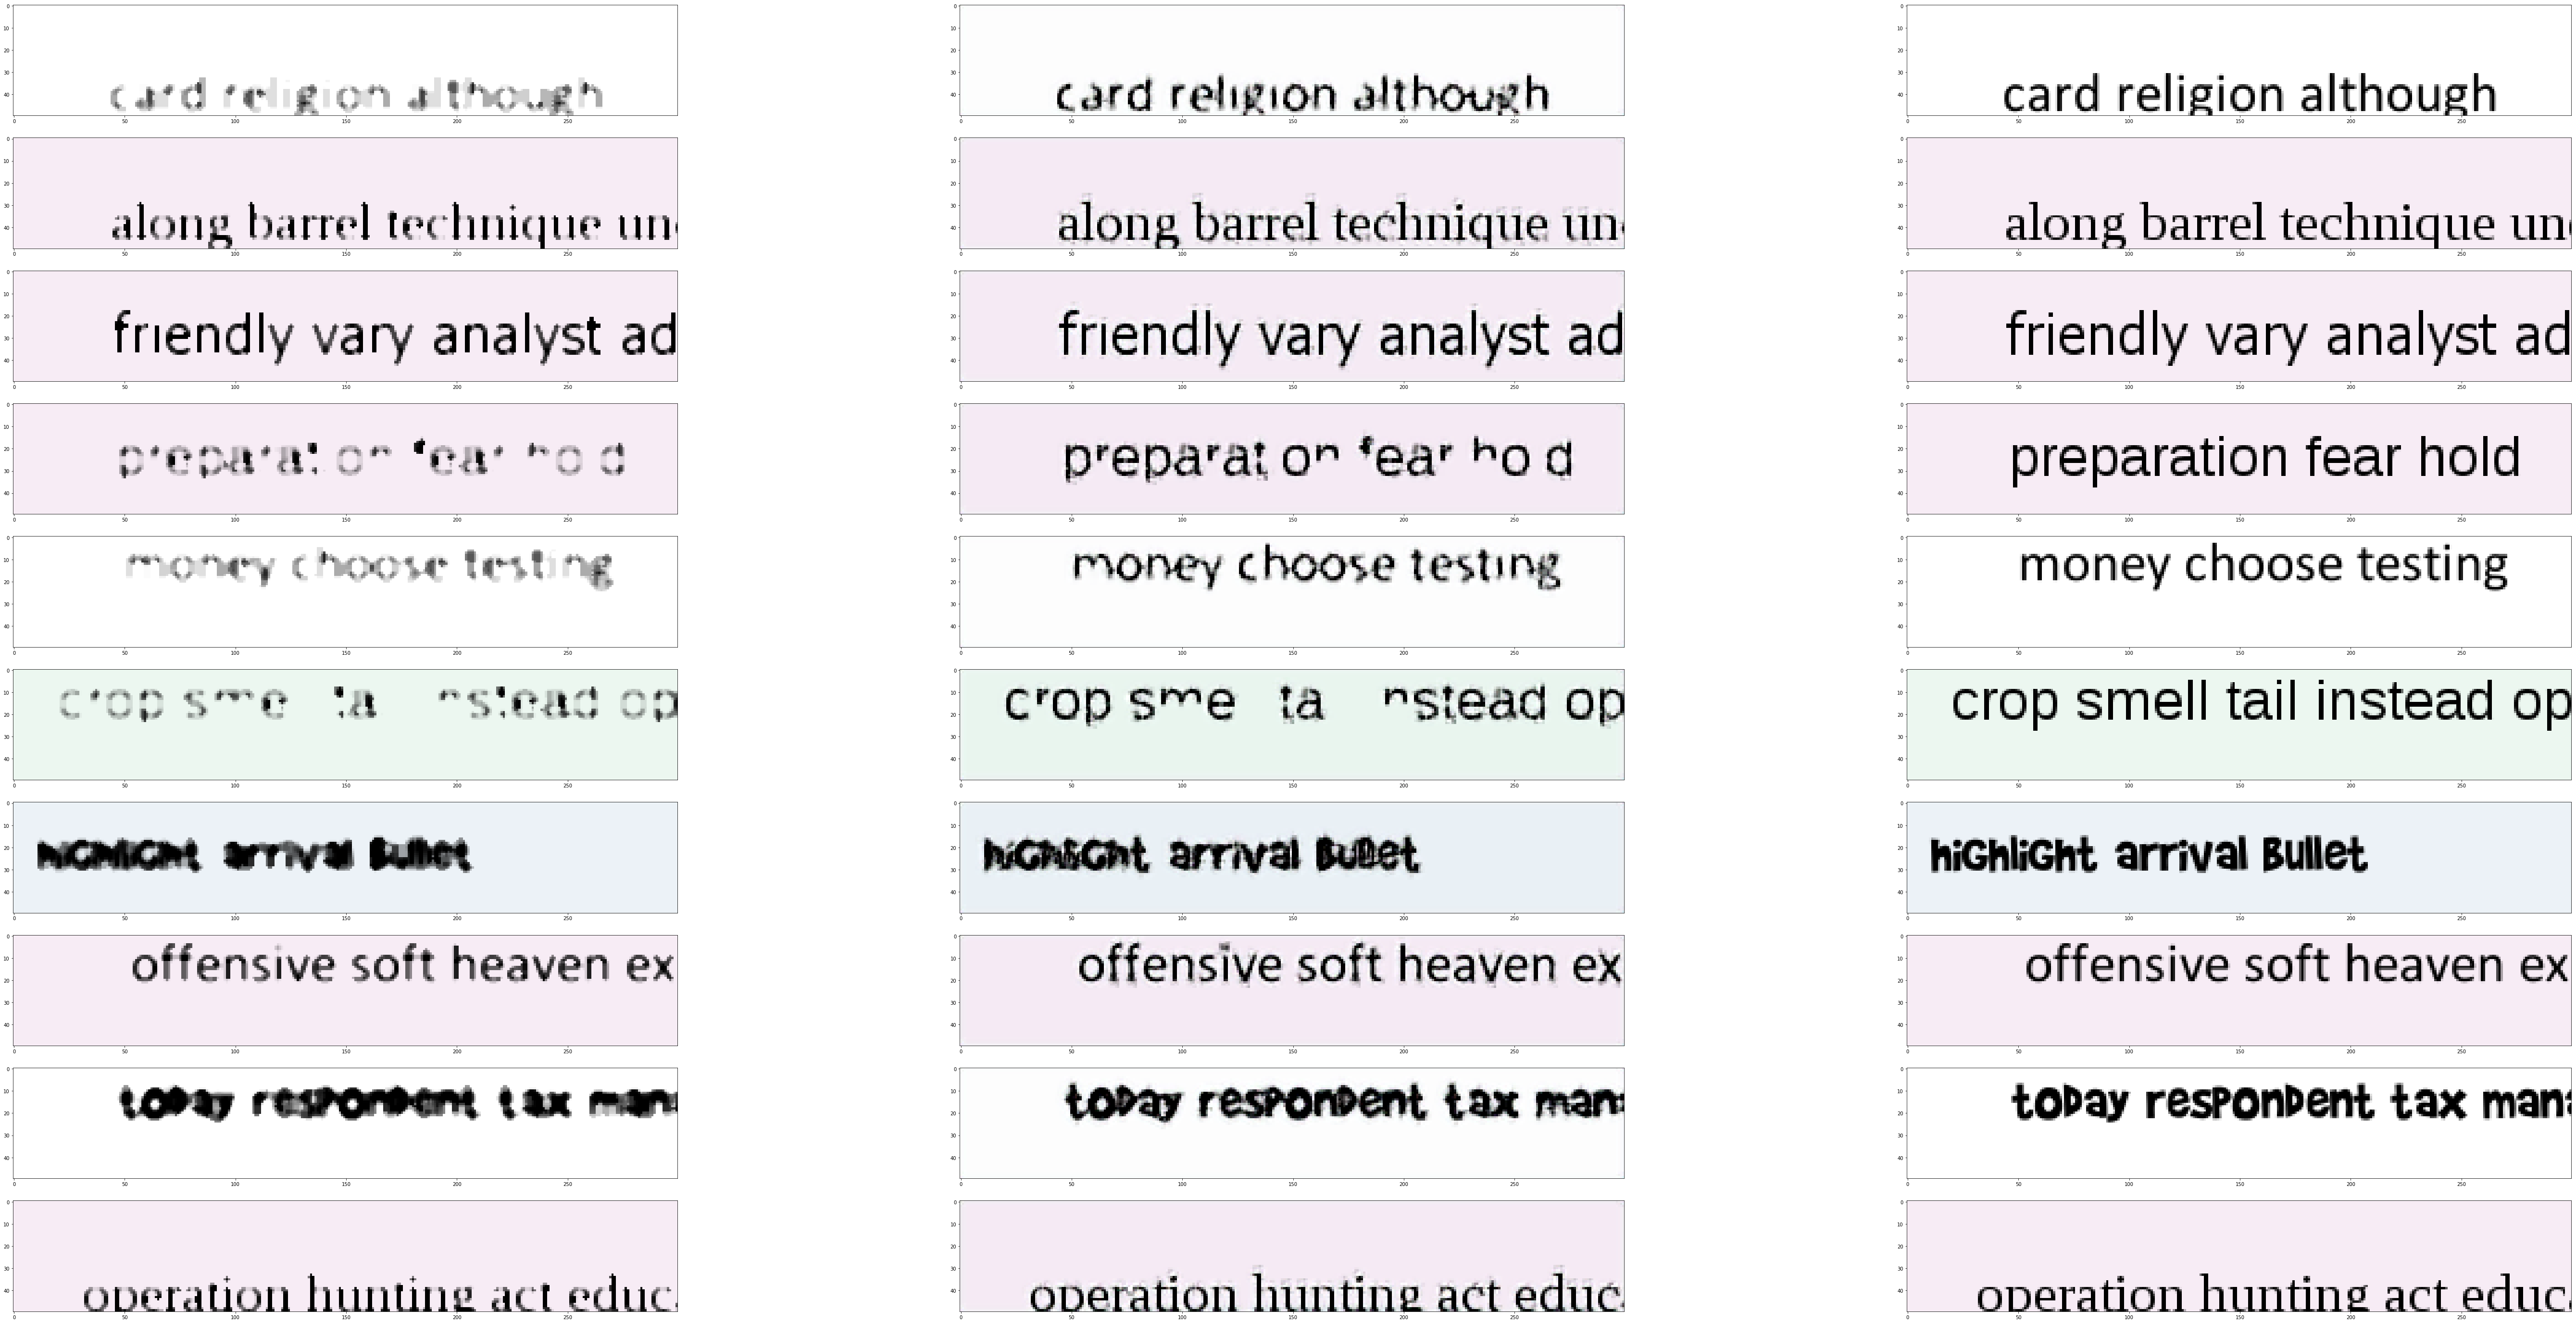

In [164]:
comparing(model, X_dev[14400:14420], y_dev[14400:14420])

In [ ]:
results = model.predict_generator(pred_generator(X_dev[:10], batch_size=10))

# Baseline

In [70]:
emodel = get_model4((100,600,1))
emodel.compile(Adam(), loss='mse', metrics=[psnr, mae])
emodel.evaluate_generator(generator([X_dev[i] for i in range(0,len(X_dev),10)]  , [y_dev[j] for j in range(0,len(y_dev),10)], batch_size=100), verbose=1)

60/60 [==============================] - 43s 723ms/step


[0.002618913435920452, 31.64958731333415, 4.073294472694397]

In [71]:
emodel.evaluate_generator(generator(X_dev[5000:10000], y_dev[5000:10000], batch_size=100), verbose=1)

50/50 [==============================] - 36s 711ms/step


[0.0018471819604746998, 33.85927417755127, 1.8146707701683045]

In [72]:
emodel.evaluate_generator(generator(X_dev[25000:30000], y_dev[25000:30000], batch_size=100), verbose=1)

50/50 [==============================] - 37s 735ms/step


[0.003606149181723595, 29.494716148376465, 6.353928689956665]

In [73]:
emodel.evaluate_generator(generator(X_dev[45000:50000], y_dev[45000:50000], batch_size=100), verbose=1)

50/50 [==============================] - 35s 707ms/step


[0.0026532701635733247, 31.130575523376464, 4.331347560882568]

In [34]:
model.evaluate_generator(generator(X_dev[5000:10000], y_dev[5000:10000], batch_size=100), verbose=1)

50/50 [==============================] - 35s 694ms/step


[0.0029100259160622956, 27.53920700073242, 4.093594384193421]

In [35]:
model.evaluate_generator(generator(X_dev[25000:30000], y_dev[25000:30000], batch_size=100), verbose=1)

50/50 [==============================] - 35s 692ms/step


[0.005849995715543628, 24.249561729431154, 8.124852361679077]

In [37]:
model.evaluate_generator(generator(X_dev[45000:50000], y_dev[45000:50000], batch_size=100), verbose=1)

50/50 [==============================] - 34s 684ms/step


[0.0035263208206743, 26.284175949096678, 5.852288408279419]

In [44]:
len(X_train)

90000

In [100]:
imread(X_train[0]).shape

(50, 300, 3)

# Test

In [5]:
X_train[:10]

['datav7/train30000/median/median0.png',
 'datav7/train30000/median/median1.png',
 'datav7/train30000/median/median2.png',
 'datav7/train30000/median/median3.png',
 'datav7/train30000/median/median4.png',
 'datav7/train30000/median/median5.png',
 'datav7/train30000/median/median6.png',
 'datav7/train30000/median/median7.png',
 'datav7/train30000/median/median8.png',
 'datav7/train30000/median/median9.png']

In [15]:
for i in range(5,9):
    upload_file(file_name = "ch8_training_images_{}.zip".format(i), content = "ch8_training_images_{}.zip.1".format(i), folder_id = root_project_dir, overwrite = False)

Uploaded file with ID 1NTcfMnvi61OlLMpBttL7NKC-l7QK1Wfs
Uploaded file with ID 1wrB9ZEi-TRB5Pjx4hFtYabYB_v3w2RDM
Uploaded file with ID 1a5sixaghYInxr4GgIopsm0mAFCG1HzYy
Uploaded file with ID 1eShkPX79lBbCM_70r5p52Jxkk43J7kSX
